# Homework 6

INSERT YOUR NAME HERE

__Directions:__ Add work to this notebook to solve the problems below.

Be careful to name the objects you create as described in the problem. Some problems may include some tests you can run to test your code.

You must do exact arithemetic unless a problem suggests otherwise!

This code below is used to conduct some of the provided tests. Execute it before working on the problems.

In [ ]:
def _pass(s):
    s = s.replace('\n','<br/>')
    from IPython.display import HTML
    display(HTML(f'<span style="color: darkgreen; ">{s}</span>'))
_pass('Results of a successful test will be printed like this.')

def _fail(s, stop=True):
    s = s.replace('\n','<br/>')
    from IPython.display import HTML
    display(HTML(f'<span style="color: red; font-weight: bold; ">{s}</span>'))
    if stop:
        raise ValueError('You failed a test')
_fail('''Results of a failed test will be printed like this.
Typically a ValueError will also be raised, causing futher execution to stop.''', stop=False)

## 1. Create a circle class

Together we will create classes to explore [Straightedge and compass constructions](https://en.wikipedia.org/wiki/Straightedge_and_compass_construction). There are five basic construtions allowed:
* Creating a line throught two points.
* Creating a circle from a center and a point on the circle.
* Obtaining the set of points where two lines intersect. (This can be an empty set, one point, or a line- if the two lines are equal.)
* Obtaining the set of points where a line and circle intersect. (This can either be zero, one or two points.)
* Obtaining the set of points where two circles intersect. (This can be zero, one, or two points, or a circle if the two are equal.)

We will use the field $\mathbb A$ of all real algebraic numbers, because the field is closed under straight-edge and compass constructions. That is, given finitely many points in $\mathbb A^2 \subset \mathbb R^2$, the only new points that can be constructed also lie in $\mathbb A^2$.

Here we construct $\mathbb A^2$ as a vector space:

In [1]:
AA2 = VectorSpace(AA, 2)

Points in `AA2` can be constructed using their coordinates: `p = AA2([x, y])`.

I have written the following class for working with lines in $\mathbb A^2$:

In [2]:
class Line:
    def __init__(self, pt1, pt2):
        'Construct a line from two points on the line.'
        pt1 = AA2(pt1) # Be sure that the inputs lie in AA2 (convert if not).
        pt2 = AA2(pt2)
        self._two_points = (pt1, pt2)
        if pt1 == pt2:
            raise ValueError('Cannot construct line using identical points!')
        n = AA2([pt2[1]-pt1[1], pt1[0]-pt2[0]])
        if n[1] != 0:
            ratio = n[1]
        else:
            ratio = n[0]
        n /= ratio
        n.set_immutable()  # Make it so that n can no longer change.
        self._normal = n
        self._b = AA(self._normal * pt1)
 
    def normal(self):
        'Return a normal vector to this line. This is a vector in AA^2.'
        return self._normal

    def two_points(self):
        'Return a pair of points on this line.'
        return self._two_points

    def equation(self):
        'Return an equation in variables x and y that describes this line.'
        x,y = var('x y')
        v = vector(SR, [x, y])
        return v*self.normal() == self._b

    def __repr__(self):
        return f'the line {self.equation()}'
    
    def __contains__(self, other):
        try:
            pt = AA2(other)
            return pt*self.normal() == self._b
        except TypeError:
            # Conversion into AA2 failed
            return False

    def __eq__(self, other):
        if not isinstance(other, Line):
            return False
        if self._normal[0] != 0:
            ratio = other._normal[0]/self._normal[0]
            return ratio*self._b == other._b and ratio*self._normal[1] == other._normal[1]
        else:
            ratio = other._normal[1]/self._normal[1]
            return ratio*self._b == other._b

    def __hash__(self):
        if self._normal[0] != 0:
            ratio = 1/self._normal[0]
        else:
            ratio = 1/self._normal[1]
        # We return the hash of a pair of normalized values (normal, b)
        # Note that we need to set the vector to be immutable.
        return hash((vector(AA, ratio*self._normal, immutable=True), ratio*self._b))

    def intersect(self, other):
        '''
        Returns the intersection of this line with `other`, which can be either a `Line` or 
        a `circle`.

        When intersecting two lines, the intersection can be either this line (if this line
        equals `other`), a single point in `AA2`, or `None` (if the two lines do not intersect).

        If `other` is a `Circle`, we call `other.intersect(self)`, leaving the work to the 
        `Circle` class.
        '''
        if isinstance(other, Line):
            if self == other:
                return self
            try:
                return matrix([
                    self.normal(),
                    other.normal()]).inverse() * AA2([self._b, other._b])
            except (TypeError, ZeroDivisionError):
                return None
        if isinstance(other, Circle):
            return other.intersect(self)
        raise TypeError('Can only intersect with other Lines and Circles.')

    def plot(self, plt, **kwds):
        '''
        Create a Graphical object drawing this line.

        The required parameter `plt` should be a Graphics object. We use this object to tell
        us where the line should be draw. We will draw the portion of the line passing through
        the rectangle.

        Keyword arguments are passed along to the `line2d` function which creates the graphical
        object.

        It is recommended that you draw other geometric objects first, producing a graphical object
        `plt` and then draw the line with the command `line.plot(plt)`. This will ensure that the
        line cuts all the way across the graphic.
        '''
        xmin = AA(floor(plt.xmin()))
        xmax = AA(ceil(plt.xmax()))
        ymin = AA(floor(plt.ymin()))
        ymax = AA(ceil(plt.ymax()))
        lines = [
            Line((xmin, 0), (xmin, 1)),
            Line((xmax, 0), (xmax, 1)),
            Line((0, ymin), (1, ymin)),
            Line((0, ymax), (1, ymax))
        ]
        points = set()
        for line in lines:
            pt = self.intersect(line)
            if pt in AA2 and xmin<=pt[0]<=xmax and ymin<=pt[1]<=ymax:
                pt.set_immutable()
                points.add(pt)
        if len(points)==2:
            default_options = dict(color='red', xmin=plt.xmin(), xmax=plt.xmax(),
                                   ymin=plt.ymin(), ymax=plt.ymax(), )
            combined_options = default_options | kwds
            return line2d(points, **combined_options)
        else:
            # Return an empty graphics object.
            return Graphics()

We briefly demonstrate the use of the `Line` class:

line1 is the line x + y == 7
Two points on line1 are (3, 4) and (6, 1)
The point (-1, 8) is in line1
line2 is the line -3/2*x + y == 0
The intersection between line1 and line2 is (14/5, 21/5)
The equation of line1 is x + y == 7


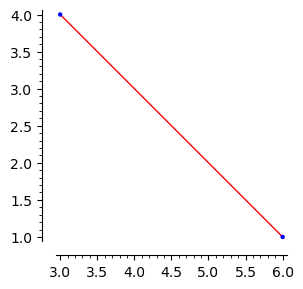

In [3]:
point_A = AA2([3,4])
point_B = AA2([6,1])

line1 = Line(point_A, point_B)

print(f'line1 is {line1}')

ptA, ptB = line1.two_points()
print(f'Two points on line1 are {ptA} and {ptB}')

if (-1, 8) in line1:
    print('The point (-1, 8) is in line1')

line2 = Line((0,0), (2,3))

print(f'line2 is {line2}')

print(f'The intersection between line1 and line2 is {line1.intersect(line2)}')

print(f'The equation of line1 is {line1.equation()}')

plt = point2d([point_A, point_B], color='blue', figsize=4, zorder=10, aspect_ratio=1)
plt + line1.plot(plt)

**Your task:** Write a class called `Circle` that represents a circle in the plane. This class should have several methods:
* An `__init__` method that constructs a circle from a `center` and a `point_on_circle`, both of which should be convertible to an element of `AA2` (by calling for instance `AA2(center)`). This method should initialize the circle.
* A method `center` which returns the center of the circle as an element of `AA2`. The vector returned should be immutable.
* A method `a_point` which returns a point in `AA2` on the circle.
* A method `radius` that returns the radius of the circle as an element of `AA`.
* A method `equation` that returns an equation whose solution set is the collection of points making up the circle. The equation should involve the coordinates `x=var('x')` and `y=var('y')`.
* A method `__repr__` which returns a string containing a readable description of the circle when called with `repr(c)`.
* A method `__contains__`. If `pt` is in `AA2` and `c` is a `Circle`, the expression `pt in c` will call `c.__contains__pt`. The function should return `True` if `pt` is a point on the circle `c` and `False` otherwise.
* A method `__eq__`. This method is called when `c == other` or `c != other` is executed. It should return `True` if `other` is a Circle that is equal to `c`, and `False` otherwise. In particular, it should return False if `other` is not a circle.
* A methof `__hash__` should be provided so 
* A method `intersect(obj)` which can be called with `obj` either a `Line` or another `Circle`. It should return `self` if `self==obj`. Otherwise it should return a `set` (possibly empty) containing all the intersection points. (*Hint:* To place an element of `AA2` in a set, you must call `set_immutable` on it first.)
* A method `plot()` for plotting the circle using the built in function `circle`. It should accept arbitrary keyword arguments, which should be passed on to `circle`. For example, you should be able to call `c.plot(color='pink', fill=True)` to fill in the circle in pink.

**Tests for your code:**

In [ ]:
# Test construction of a circle
try:
    c = Circle(AA2((0,0)), AA2((3,4)))
    print(f'The circle c is {c}')
except Exception as e:
    _fail(f'Attempting to construct a circle resulted in an error: {e}')
_pass('If the text printed above makes sense, then this test is fine.')

In [ ]:
# Test center and radius
try:
    c = Circle(AA2((5,-3)), AA2((3,1)))
    center = c.center()
    radius = c.radius()
except Exception as e:
    _fail(f'There were errors above: {e}')
if center != AA2((5,-3)):
    _fail('The center of c is incorrect.')
if radius != AA(2*sqrt(5)):
    _fail('The radius of c is incorrect.')
_pass('The center and radius tests were passed.')

In [ ]:
# Test equation()
try:
    c = Circle(AA2((0,0)), AA2((1,1)))
    eq = c.equation()
except Exception as e:
    _fail(f'There were errors above: {e}')
if not set(eq.variables()) == {var('x'), var('y')}:
    _fail('The equation is in the wrong variables.')
if not bool(eq.subs({var('x'): AA(sqrt(2)), var('y'): 0})):
    _fail('The equation improperly said (sqrt(2), 0) is not on the circle.')
if bool(eq.subs({var('x'): 0, var('y'): 0})):
    _fail('The equation improperly said (0, 0) is on the circle.')
if bool(eq.subs({var('x'): 0, var('y'): -2})):
    _fail('The equation improperly said (0, -2) is on the circle.')
_pass('The equation tests were passed.')

In [ ]:
# test __repr__
try:
    c = Circle(AA2((0,0)), AA2((sqrt(2),1)))
    s = repr(c)
except Exception as e:
    _fail(f'There were errors above: {e}')
if 'main' in s:
    _fail('It seems __repr__ was not written.')
_pass('The __repr__ tests were passed.')

In [ ]:
# Test __contains__
try:
    c = Circle(AA2((0,0)), AA2((3,4)))
    bool1 = AA2((-5,0)) in c
    bool2 = AA2((2,sqrt(21))) in c
    bool3 = AA2((0,0)) in c
    bool4 = AA2((6,0)) in c
except Exception as e:
    _fail(f'There were errors above: {e}')
if not bool1:
    _fail('Your code wrongly declared that (-5,0) was not in c.')
if not bool2:
    _fail('Your code wrongly declared that (2, sqrt(21)) was not in c.')
if bool3:
    _fail('Your code wrongly declared that (0,0) was is in c. (Being "in" means on the boundary.)')
if bool4:
    _fail('Your code wrongly declared that (6,0) was is in c. (Being "in" means on the boundary.)')
_pass('The __contains__ tests were passed.')  

In [ ]:
# Test a_point()
try:
    c = Circle(AA2((1,1)), AA2((2,3)))
    pt = c.a_point()
    bool1 = pt in c
except Exception as e:
    _fail(f'There were errors in the try block above: {e}')
if not bool1:
    _fail(f'Your code asserts that the point returned by a_point() is not in c.')
_pass('The a_point() test was passed.') 

In [ ]:
# Test __eq__
try:
    c1 = Circle(AA2((0,0)), AA2((3,4)))
    c2 = Circle(AA2((0,0)), AA2((5,0)))
    bool1 = c1 != c2
    c3 = Circle(AA2((6,0)), AA2((3,4)))
    bool2 = c1 == c3
    c4 = Circle(AA2((6,0)), AA2((6,sqrt(5))))
    bool3 = c3 == c4
except Exception as e:
    _fail(f'There were errors in the first try block above: {e}')
if bool1:
    _fail('Your code wrongly declared that c1 and c2 are different.')
if bool2:
    _fail('Your code wrongly declared that c1 and c3 are equal.')
if bool3:
    _fail('Your code wrongly declared that c3 and c4 are equal.')
try:
    l = Line(AA2((0,0)), AA2((3,4)))
    bool4 = c1 == l
except Exception as e:
    _fail(f'There were errors in the second try block above: {e}')
if bool4:
    _fail('Your code wrongly declared that c1 and a line are equal.')
_pass('The __eq__ tests were passed.')  

In [ ]:
# test __hash__
try:
    c1 = Circle(AA2((0,0)), AA2((3,4)))
    c2 = Circle(AA2((0,0)), AA2((5,0)))
    hash1 = hash(c1)
    hash2 = hash(c2)
    hash3 = hash(c3)
    hash4 = hash(c4)
except Exception as e:
    _fail(f'There were errors in the try block above: {e}')
if hash1 != hash2:
    _fail('The hashes of circles c1 and c2 are different but the circles are equal!')
if hash1 == hash3:
    print('The hashes of c1 and c3 are equal. This is a hash collision (which is bad!).')
if hash1 == hash4:
    print('The hashes of c1 and c4 are equal. This is a hash collision (which is bad!).')
if hash3 == hash4:
    print('The hashes of c3 and c4 are equal. This is a hash collision (which is bad!).')
_pass('The __hash__ tests were passed. Hopefully nothing is printed above.')

In [ ]:
# test intersect two circles
try:
    c1 = Circle(AA2((0,0)), AA2((1,0)))
    c2 = Circle(AA2((1,0)), AA2((0,0)))
    c3 = Circle(AA2((2,0)), AA2((2,3)))
    i1 = c1.intersect(c2)
    i2 = c1.intersect(c3)
    i3 = c2.intersect(c3)
except Exception as e:
    _fail(f'There were errors in the first try block above: {e}')
if not isinstance(i1, set):
    _fail('The intersection of c1 and c2 is not a set.')
if not isinstance(i2, set):
    _fail('The intersection of c1 and c3 is not a set.')
if not isinstance(i3, set):
    _fail('The intersection of c2 and c3 is not a set.')
if set(i1) != {vector(AA, (1/2,  sqrt(3)/2), immutable=True), 
               vector(AA, (1/2, -sqrt(3)/2), immutable=True)}:
    _fail('The intersection of c1 and c2 is incorrect.')
if set(i2) != {vector(AA, (-1,  0), immutable=True)}:
    _fail('The intersection of c1 and c3 is incorrect.')
if set(i3) != set():
    _fail('The intersection of c2 and c3 is incorrect.')
_pass('All tests related to intersecting two circles were passed.')

In [ ]:
# test intersect with a line
try:
    c1 = Circle(AA2((0,0)), AA2((5,0)))
    l1 = Line(AA2((0,3)), AA2((1,3)))
    l2 = Line(AA2((6,7)), AA2((10,3)))
    l3 = Line(AA2((5*sqrt(2),0)), AA2((0,5*sqrt(2))))
    i1 = c1.intersect(l1)
    i2 = c1.intersect(l2)
    i3 = c1.intersect(l3)
except Exception as e:
    _fail(f'There were errors in the first try block above: {e}')
if not isinstance(i1, set):
    _fail('The intersection of c1 and l1 is not a set.')
if not isinstance(i2, set):
    _fail('The intersection of c1 and l2 is not a set.')
if not isinstance(i3, set):
    _fail('The intersection of c1 and l3 is not a set.')
if set(i1) != {vector(AA, ( 4, 3), immutable=True), 
               vector(AA, (-4, 3), immutable=True)}:
    _fail('The intersection of c1 and l1 is incorrect.')
if set(i2) != set():
    _fail('The intersection of c1 and l2 is incorrect.')
if set(i3) != {vector(AA, (5*sqrt(2)/2,  5*sqrt(2)/2), immutable=True)}:
    _fail('The intersection of c1 and l3 is incorrect.')
_pass('All tests related to intersecting a circle with a line were passed.')

In [ ]:
# test basic plotting
try:
    c1 = Circle(AA2((2,1)), AA2((4,2)))
    plt = c1.plot()
except Exception as e:
    _fail(f'There were errors in the first try block above: {e}')
if not isinstance(plt, Graphics):
    _fail('Calling plot on c1 did not return a Graphics object.')
show(plt)
_pass('Assuming the circle looks fine, this test was successful.')

In [ ]:
# test more elaborate plotting
try:
    c0 = Circle(AA2((0,0)), AA2((3,4)))
    c = Circle(AA2((3,4)), AA2.zero())
    circles = {c}
    centers = {vector(AA, c.center(), immutable=True)}
    while len(circles) < 6:
        new_centers = []    
        for c in circles:
            for pt in c0.intersect(c):
                if pt not in centers:
                    new_centers.append(pt)
        for pt in new_centers:
            circles.add(Circle(pt, AA2.zero()))
            centers.add(pt)
    plt = c0.plot(color='black', zorder=0, axes=False)
    for c in circles:
        plt += c.plot(fill=True, alpha=0.20, color='purple', zorder=0)
except Exception as e:
    _fail(f'There were errors in the first try block above: {e}')
if not isinstance(plt, Graphics):
    _fail('We did not produce a graphics object.')
show(plt)
_pass('A picture related to the construction of a regular hexagon should appear above. If so, the test is passed.')

## 2. Perpendicular Bisector

It is a classic basic problem to construct a line $\ell$ that bisects a line segment $\overline{AB}$. Write a function `perpendicular_bisector(ptA, ptB, graphics=False)`. There should be two different behaviors depending on whether the keyword parameter `graphics` is set to True or False. (It should default to `False`.)

If `plot` is False, the function should return the `Line` that is perpendicular to and bisects the segment $\overline{AB}$. You should only use compass and straight-edge constructions. That is, you can construct a `Line` (from two points you construct), you can construct a `Circle` (from already constructed center and a point on the circle), and you can intersect these objects using the `intersect` method to obtain points.

If `graphics` is set to `True`, the function should return a pair `(l, plt)` where `l` is the perpendicular bisector as above and `plt` is a Graphics object that depicts the objects under consideration. You can use `point2d` to plot points, `line2d` for line segments, and the `plot()` methods of `Line` and `Circle` to create the plot.

**Tests for your code:**

In [ ]:
try:
    pb = perpendicular_bisector(AA2((0,0)), AA2((1,0)))
    ans = Line(AA2((1/2,0)), AA2((1/2,1)))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if pb != ans:
    _fail('The perpendicular bisector `pb` is incorrect.')
_pass('The perpendicular bisector you computed is correct.')

In [ ]:
try:
    pb = perpendicular_bisector(AA2((3,-2)), AA2((7,5)))
    ans = Line(AA2((0,61/14)), AA2((5,3/2)))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if pb != ans:
    _fail('The perpendicular bisector `pb` is incorrect.')
_pass('The perpendicular bisector you computed is correct.')

In [ ]:
# Testing the plot feature
try:
    l,plt = perpendicular_bisector(AA2((1,1)), AA2((3,4)), graphics=True)
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if not isinstance(plt, Graphics):
    _fail('The returned plt should be a Graphics object')
show(plt)
_pass('Hopefully the construction above appears correct.')

## 3. The circle through three points

Given three distinct points $A$, $B$ and $C$, we will construct the circle or line through all three.

Write a function `circle_through(ptA, ptB, ptC, graphics=False)` which produces the line or circle through all three points. The line $\overline{AB}$ should be returned if $C$ is on this line. The circle through these points should be returned otherwise.

*Remarks:* 
* Note that the center of the circle through three points is a point that is equidistant from all three points.
* You can tell if a point `ptC` lies on a line `l` by calling `ptC in l`.

As in the previous problem, if `graphics` is set to `True`, then you should return a pair `(obj, plt)` where `obj` is either the line or circle containing the three points, and `plt` is a graphics object depicting the construction. If you use `perpendicular_bisector`, you can just plot the lines produced rather than the whole construction.

**Tests for your code:**

In [ ]:
try:
    c = circle_through(AA2([-5, 0]), AA2([0, 5]), AA2([4, 3]))
    ans = Circle(AA2([0, 0]), AA2([5, 0]))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if c != ans:
    _fail('The returned geometric object is incorrect!')
_pass('Your code passed this test')

In [ ]:
try:
    c = circle_through(AA2([-4, 3]), AA2([1, 1]), AA2([11, -3]))
    ans = Line(AA2([-4, 3]), AA2([1, 1]))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if c != ans:
    _fail('The returned geometric object is incorrect!')
_pass('Your code passed this test')

In [ ]:
try:
    c,plt = circle_through(AA2([1, 1]), AA2([2, -1]), AA2([4, 1]), graphics=True)
    ans = Circle(AA2([5/2, 1/2]), AA2([1, 1]))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if c != ans:
    _fail('The returned geometric object is incorrect!')
if not isinstance(plt, Graphics):
    _fail('The second item returned was not a graphics object.')
show(plt)
_pass('Your code passed this test')

In [ ]:
try:
    c,plt = circle_through(AA2([1, 1]), AA2([2, -1]), AA2([-1, 5]), graphics=True)
    ans = Line(AA2([1, 1]), AA2([2, -1]))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if c != ans:
    _fail('The returned geometric object is incorrect!')
if not isinstance(plt, Graphics):
    _fail('The second item returned was not a graphics object.')
show(plt)
_pass('Your code passed this test')

## 4. Constructing a tangent line

Given a circle $c$ and a point $P$ on the circle, construct the tangent line $\ell$ to $c$ at the point $P$. Write a function `tangent_line_to_circle(c, ptP, graphics=False)` that returns this tangent line. You may use the `perpendicular_bisector` method you wrote in the previous problem. You may also access the center of the circle with `c.circle()`.

As in the previous problem, if `graphics` is set to `True`, then you should return a pair `(l, plt)` where `l` is the tangent line and `plt` is a graphics object depicting the objects produced in the construction. If you use `perpendicular_bisector`, you can just plot the lines produced not the whole construction.

In addition, produce an interactive plot (an `interact`) that allows you to pick the two points $C$ and $P$ by entering coordinates and draws the construction. Here $c$ should be taken to be the circle with center $C$ through $P$. (*Remark:* I had some trouble minor problems with the interact: you should be sure to convert the inputs into `AA2`.)

**Tests for your code:**

In [ ]:
try:
    ptC = AA2((0,0))
    ptP = AA2((1,0))
    c = Circle(ptC, ptP)
    l = tangent_line_to_circle(c, ptP)
    ans = Line(AA2((1,0)), AA2((1,1)))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if l != ans:
    _fail('The line produced above is incorrect.')
_pass('Great. You produced the correct line.')

In [ ]:
try:
    ptC = AA2((1,1))
    ptP = AA2((2,3))
    c = Circle(ptC, ptP)
    l = tangent_line_to_circle(c, ptP)
    ans = Line(AA2((2, 3)), AA2((0, 4)))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if l != ans:
    _fail('The line produced above is incorrect.')
_pass('Great. You produced the correct line.')

In [ ]:
try:
    ptC = AA2((2,1))
    ptP = AA2((5,3))
    c = Circle(ptC, ptP)
    l,plt = tangent_line_to_circle(c, ptP, graphics=True)
    ans = Line(AA2((5, 3)), AA2((0, 21/2)))
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if l != ans:
    _fail('The line produced above is incorrect.')
if not isinstance(plt, Graphics):
    _fail('The second item produced was not a graphical object!')
show(plt)
_pass('You produced the correct line. The construction should be depicted above.')

## 5. Perpendicular circle

Given a circle $c_1$ and two points $A$ and $B$ on the circle, we will construct circle or line $c_2$ that passes through $A$ and $B$ and is perpendicular to the circle $c_1$ at these points. Note that if $A$ and $B$ are antipodal points, then the constructed object should be the line $c_2 = \overline{AB}$. Otherwise, $c_2$ should be a circle. What can you say about the center of $c_2$ in this case?

Write a function `perpendicular_circle(c1, ptA, ptB, graphics=False)` which takes as input a circle `c1` and two points `ptA` and `ptB` and returns a line or circle $c_2$ as described above.

As in the previous problems, if `graphics` is set to `True`, then you should return a pair `(c2, plt)` where `c2` is $c_2$ and `plt` is a Graphics object depicting the construction. You may use any previous geometric constructions.

**Tests for your code:**

In [ ]:
try:
    ptC = AA2([0, 0])
    ptA = AA2([5, 0])
    ptB = AA2([3, 4])
    c1 = Circle(ptC, ptA)
    c2 = perpendicular_circle(c1, ptA, ptB)
    ans = Circle(AA2([5,5/2]), ptA)
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if c2 != ans:
    _fail('The perpendicular circle is incorrect.')
_pass('Great! The perpendicular circle you computed is correct.')

In [ ]:
try:
    ptC = AA2([3, 2])
    ptA = AA2([5, 0])
    ptB = AA2([1, 4])
    c1 = Circle(ptC, ptA)
    c2 = perpendicular_circle(c1, ptA, ptB)
    ans = Line(ptC, ptA)
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if c2 != ans:
    _fail('The perpendicular circle is incorrect. (It should be a line.)')
_pass('Great! The perpendicular line you computed is correct.')

In [ ]:
try:
    ptC = AA2([1, 3])
    ptA = AA2([-2, 1])
    ptB = AA2([4, 1])
    c1 = Circle(ptC, ptA)
    c2,plt = perpendicular_circle(c1, ptA, ptB, graphics=True)
    ans = Circle(AA2([1,-7/2]), ptA)
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if c2 != ans:
    _fail('The perpendicular circle is incorrect.')
if not isinstance(plt, Graphics):
    _fail('The returned plt should be a Graphics object')
show(plt)
_pass('Hopefully the construction looks correct.')

In [ ]:
try:
    ptC = AA2([2, 4])
    ptA = AA2([-2, 1])
    ptB = AA2([6, 7])
    c1 = Circle(ptC, ptA)
    c2,plt = perpendicular_circle(c1, ptA, ptB, graphics=True)
    ans = Line(ptB, ptA)
except Exception as e:
    _fail(f'Executing the first try block above resulted in an error: {e}')
if c2 != ans:
    _fail('The perpendicular circle is incorrect.')
if not isinstance(plt, Graphics):
    _fail('The returned plt should be a Graphics object')
show(plt)
_pass('Hopefully the construction looks correct.')